![](https://cdn.statically.io/img/thakoni.com/f=auto%2Cq=30/wp-content/uploads/2020/06/1591106722_Lucifer-Season-5-Release-Date-Cast-Netflix-And-Everything-You.jpg)
# Homework02 netflix Movie Recommendation 

Inspired by week02 I loaded a dataset of recommended movies and combined it with week08 to create a visualisation.

# COMBINE WEEK08 WEEK02

## DATA:
This code uses several Python libraries and methods to implement a movie recommendation system with data analysis and visualisation

Data source 
Method source:https://www.kaggle.com/code/laowingkin/netflix-movie-recommendation/notebook


## Methods:
Load user rating data from combined_data_1.txt and handle missing values.
Load movie titles data from movie_titles.csv and process missing values.
Plot the distribution of ratings, the distribution of the number of movie ratings, the distribution of the number of user ratings, and the heat map of ratings.
Perform cluster analysis of movies using ``KMeans`` and visualise the clustering results.
Construct recommender system using ``SVD`` algorithm and cross validate it.
Predict movie ratings for a specific user (ID 785314) and output the top 10 movies with the highest predicted ratings.
Based on Pearson's correlation coefficient, recommend the top 10 films that are similar to a particular film.
Filter out movies and users with fewer ratings based on the quartile of the number of ratings (70%) to reduce data sparsity.

## OBJECTIVE:

The goal is to build an efficient and accurate movie recommendation system through data analysis and machine learning methods, and to provide personalised movie recommendation services for users. At the same time, the data features and model results are shown through visual means to help users better understand the operation of the recommendation system

## output:

Data set information and statistical results.
Visualisation charts (e.g. ratings distribution, clustering results, etc.).
Recommender system results (e.g. personalised recommendations and movie-based recommendations).
Model evaluation results (e.g., RMSE and MAE values for SVD).

## Advantages

The code structure is clear, divided into several modules such as data loading, data exploration, recommendation system construction and recommendation result display, which is easy to understand and expand.
Supports multiple recommendation methods (SVD and correlation-based recommendation), users can choose the appropriate method according to their needs.
Through data analysis and visualisation, user behaviour and movie characteristics are deeply explored, providing data support for the recommendation system.
By filtering sparse data and using efficient algorithms (e.g. SVD), the operation efficiency of the recommendation system is improved.

## Disadvantages

The code only loads the combined_data_1.txt file, not the complete Netflix Prize dataset (combined_data_2.txt, combined_data_3.txt, combined_data_4.txt), which may lead to less comprehensive recommendation results.
The SVD algorithm and Pearson correlation coefficient calculations may be slow on large-scale datasets, especially when the number of users and films is high.
For new users or new films, the recommender system may not be able to provide accurate recommendation results due to the lack of rating data.
Cluster analysis is only based on the year feature of the film and does not consider other features (e.g. genre, director, etc.), which may lead to less accurate clustering results.
Multiple visualisation charts are generated in the code, which may increase runtime and memory consumption.

In [1]:
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
# sns.set_style("darkgrid")

Loading the Netflix Prize dataset

In [3]:
# Skip date
df1 = pd.read_csv('E:/work_daily/202503/0316/Netflix_Prize_data/combined_data_1.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])

df1['Rating'] = df1['Rating'].astype(float)

print('Dataset 1 shape: {}'.format(df1.shape))
print('-Dataset examples-')
print(df1.iloc[::5000000, :])

Dataset 1 shape: (24058263, 2)
-Dataset examples-
          Cust_Id  Rating
0              1:     NaN
5000000   2560324     4.0
10000000  2271935     2.0
15000000  1921803     2.0
20000000  1933327     3.0


Now we combine datasets:

In [4]:
# load less data for speed

df = df1

df.index = np.arange(0,len(df))
print('Full dataset shape: {}'.format(df.shape))
print('-Dataset examples-')
print(df.iloc[::5000000, :])

Full dataset shape: (24058263, 2)
-Dataset examples-
          Cust_Id  Rating
0              1:     NaN
5000000   2560324     4.0
10000000  2271935     2.0
15000000  1921803     2.0
20000000  1933327     3.0


## Data viewing

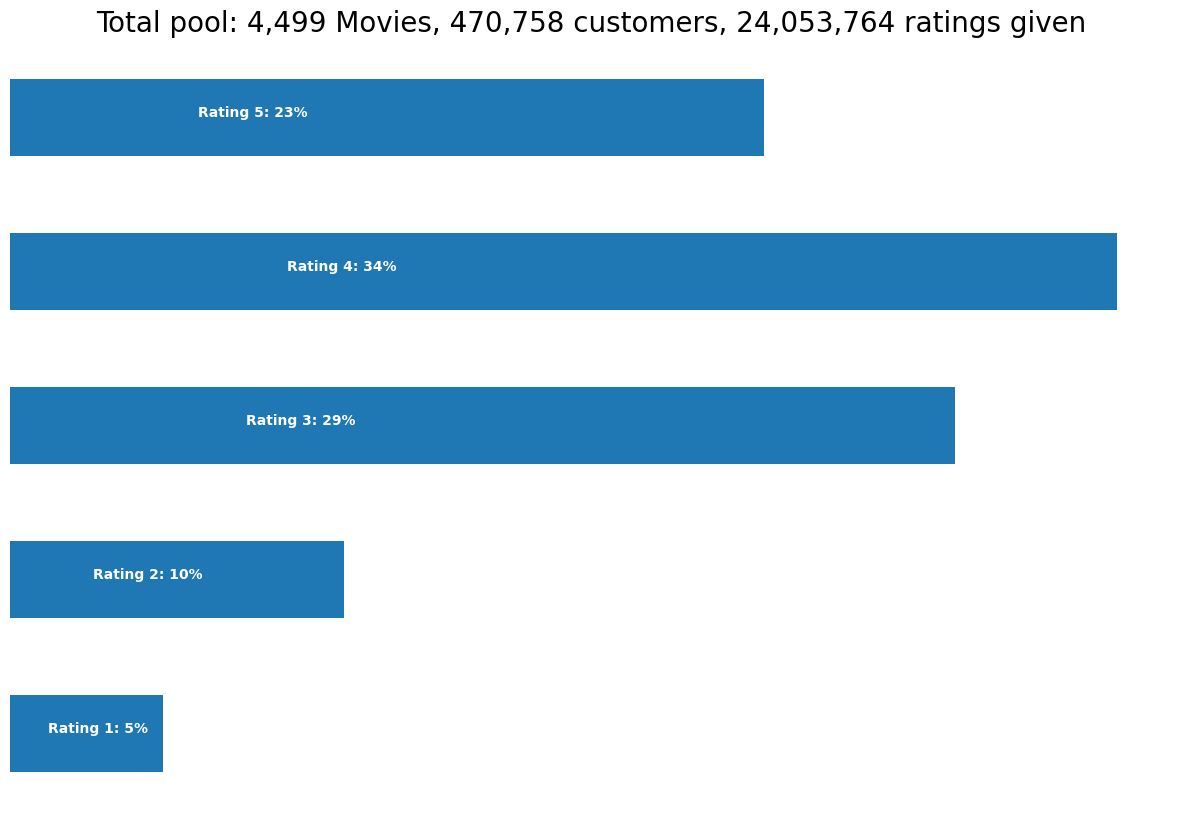

In [5]:
p = df.groupby('Rating')['Rating'].agg(['count'])

# get movie count
movie_count = df.isnull().sum()[1]

# get customer count
cust_count = df['Cust_Id'].nunique() - movie_count

# get rating count
rating_count = df['Cust_Id'].count() - movie_count

ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')



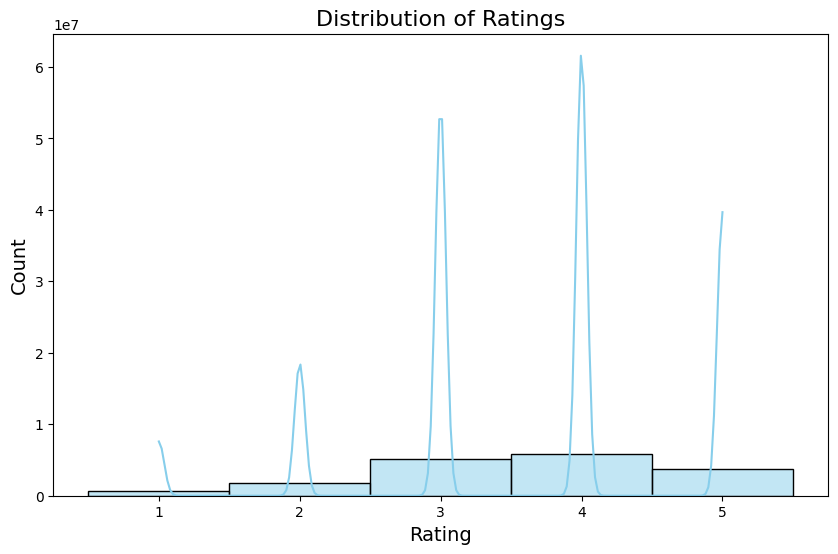

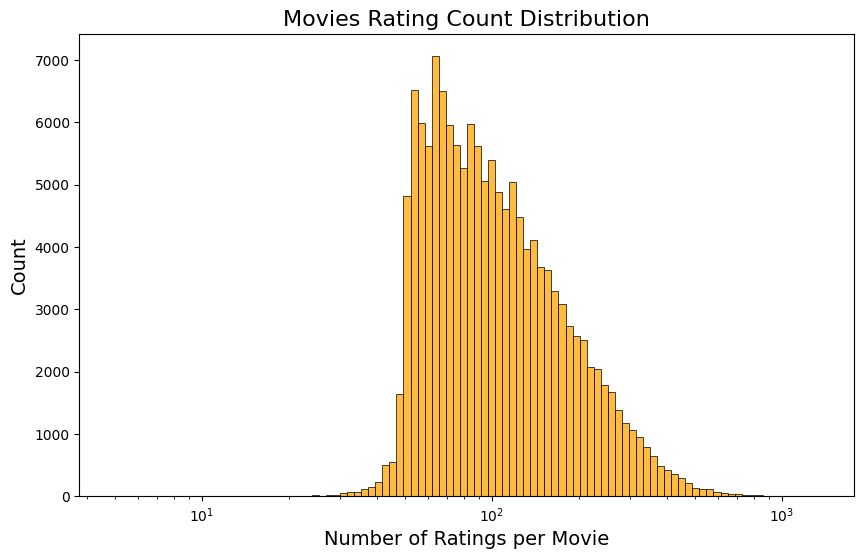

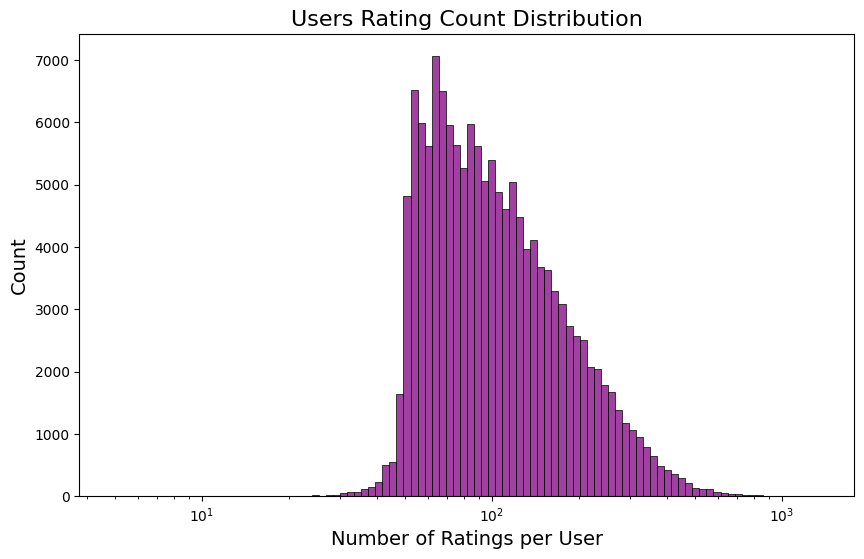

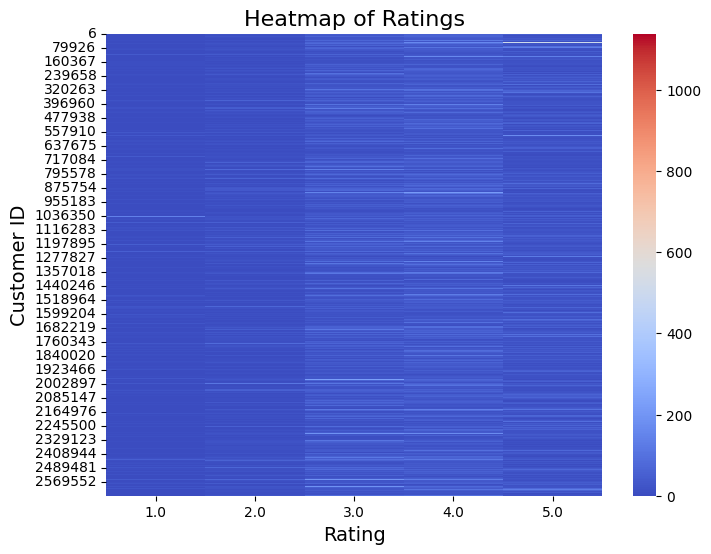

In [ ]:
# 1. Histogram: distribution of user ratings
plt.figure(figsize=(10, 6))
sns.histplot(df['Rating'].dropna(), bins=5, kde=True, discrete=True, color='skyblue')
plt.xlabel("Rating", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("Distribution of Ratings", fontsize=16)
plt.show()

# 2. Counting the number of ratings for each film
movie_ratings = df.groupby('Cust_Id')['Rating'].count()
plt.figure(figsize=(10, 6))
sns.histplot(movie_ratings, bins=100, log_scale=True, color='orange')
plt.xlabel("Number of Ratings per Movie", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("Movies Rating Count Distribution", fontsize=16)
plt.show()

# 3. Counting the number of ratings per user
user_ratings = df.groupby('Cust_Id')['Rating'].count()
plt.figure(figsize=(10, 6))
sns.histplot(user_ratings, bins=100, log_scale=True, color='purple')
plt.xlabel("Number of Ratings per User", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("Users Rating Count Distribution", fontsize=16)
plt.show()

# 4. Ratings Heat Map
plt.figure(figsize=(8, 6))
pivot_table = df.pivot_table(index='Cust_Id', columns='Rating', aggfunc='size', fill_value=0)
sns.heatmap(pivot_table, cmap='coolwarm', cbar=True)
plt.xlabel("Rating", fontsize=14)
plt.ylabel("Customer ID", fontsize=14)
plt.title("Heatmap of Ratings", fontsize=16)
plt.show()


We can see that the rating tends to be relatively positive (>3). This may be due to the fact that unhappy customers tend to just leave instead of making efforts to rate.

## Data cleaning

Iterate through the indexes in ``df_nan`` and use ``numpy`` to create an array ``temp`` containing the current movie ID and append it to ``movie_np.`` The film ID is then incremented.

In [6]:
df_nan = pd.DataFrame(pd.isnull(df.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()

movie_np = []
movie_id = 1

for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    # numpy approach
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1

# Account for last record and corresponding length
# numpy approach
last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

print('Movie numpy: {}'.format(movie_np))
print('Length: {}'.format(len(movie_np)))

Movie numpy: [1.000e+00 1.000e+00 1.000e+00 ... 4.499e+03 4.499e+03 4.499e+03]
Length: 24053764


In [7]:
# remove those Movie ID rows
df = df[pd.notnull(df['Rating'])]

df['Movie_Id'] = movie_np.astype(int)
df['Cust_Id'] = df['Cust_Id'].astype(int)
print('-Dataset examples-')
print(df.iloc[::5000000, :])


-Dataset examples-
          Cust_Id  Rating  Movie_Id
1         1488844     3.0         1
5000996    501954     2.0       996
10001962   404654     5.0      1962
15002876   886608     2.0      2876
20003825  1193835     2.0      3825


C:\Users\hjx\AppData\Local\Temp\ipykernel_126188\1628938347.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Movie_Id'] = movie_np.astype(int)
C:\Users\hjx\AppData\Local\Temp\ipykernel_126188\1628938347.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cust_Id'] = df['Cust_Id'].astype(int)


## Data slicing

The data set now is super huge. I have tried many different ways but can't get the Kernel running as intended without memory error. Therefore I tried to reduce the data volumn by improving the data quality below:

* Remove movie with too less reviews (they are relatively not popular)
* Remove customer who give too less reviews (they are relatively less active)

Having above benchmark will have significant improvement on efficiency, since those unpopular movies and non-active customers still occupy same volumn as those popular movies and active customers in the view of matrix (NaN still occupy space). This should help improve the statistical signifiance too.

Let's see how it is implemented:

In [8]:
f = ['count','mean']

df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.7),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.7),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))

Movie minimum times of review: 1799.0
Customer minimum times of review: 52.0


Now let's trim down our data.

In [9]:
print('Original Shape: {}'.format(df.shape))
df = df[~df['Movie_Id'].isin(drop_movie_list)]
df = df[~df['Cust_Id'].isin(drop_cust_list)]
print('After Trim Shape: {}'.format(df.shape))
print('-Data Examples-')
print(df.iloc[::5000000, :])

Original Shape: (24053764, 3)
After Trim Shape: (17337458, 3)
-Data Examples-
          Cust_Id  Rating  Movie_Id
696        712664     5.0         3
6932490   1299309     5.0      1384
13860273   400155     3.0      2660
20766530   466962     4.0      3923


A pivot table df_p is created using the pd.pivot_table function, where Cust_Id is used as the row index, Movie_Id as the column index, and Rating as the value. The shape of the pivot table shows the number of users and movies.

In [10]:
df_p = pd.pivot_table(df,values='Rating',index='Cust_Id',columns='Movie_Id')

print(df_p.shape)


(143458, 1350)


## Data mapping

Now we load the movie mapping file:

Top five rows of raw data：
            Year                          Name
Movie_Id                                      
1         2003.0               Dinosaur Planet
2         2004.0    Isle of Man TT 2004 Review
3         1997.0                     Character
4         1994.0  Paula Abdul's Get Up & Dance
5         2004.0      The Rise and Fall of ECW
The first five rows of feature data:
            Year
Movie_Id        
1         2003.0
2         2004.0
3         1997.0
4         1994.0
5         2004.0
Amount of NaN in normalised data： 0
Number of Inf in standardised data： 0
Standardised data shapes：(17434, 1)
Data shape after filling in missing values：(17434, 1)


D:\anaconda3\envs\pytorch\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 系统找不到指定的文件。
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "D:\anaconda3\envs\pytorch\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "D:\anaconda3\envs\pytorch\lib\subprocess.py", line 493, in run
    with Popen(*popenargs, **kwargs) as process:
  File "D:\anaconda3\envs\pytorch\lib\subprocess.py", line 858, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "D:\anaconda3\envs\pytorch\lib\subprocess.py", line 1327, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


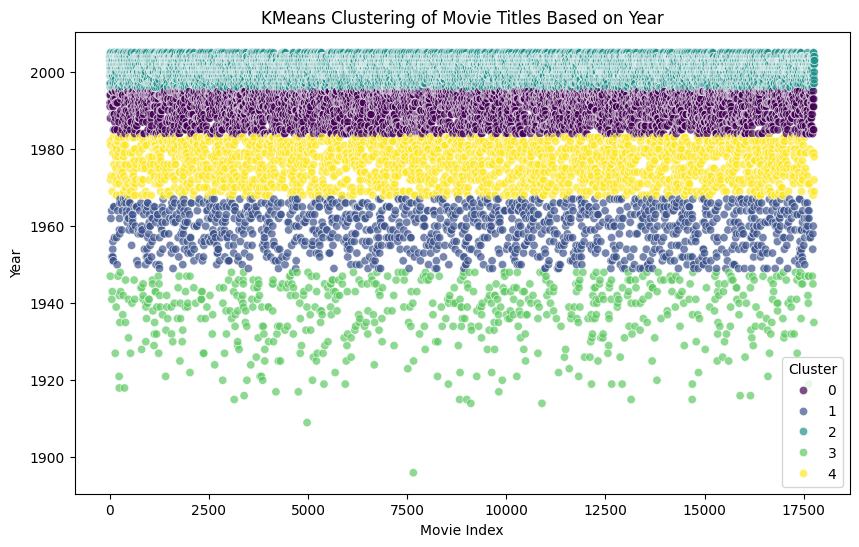

In [12]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Reading film data (Netflix Prize data is comma-separated)
file_path = 'E:/work_daily/202503/0316/Netflix_Prize_data/movie_titles.csv'
df_title = pd.read_csv(file_path, sep=',', encoding='ISO-8859-1', header=None, names=['Movie_Id', 'Year', 'Name'], on_bad_lines='skip')

# Set Movie_Id as index
df_title.set_index('Movie_Id', inplace=True)

# Checking data
print("Top five rows of raw data：")
print(df_title.head())

# Dealing with missing values in the Year column, populated with the median
df_title['Year'].fillna(df_title['Year'].median(), inplace=True)

# Select features (only the Year column is used here)
df_features = df_title[['Year']]

# Inspection of characterisation data
print("The first five rows of feature data:")
print(df_features.head())

# Standardised data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_features)

# Checking for problems with standardised data
print("Amount of NaN in normalised data：", np.isnan(df_scaled).sum()) 
print("Number of Inf in standardised data：", np.isinf(df_scaled).sum()) 
print(f"Standardised data shapes：{df_scaled.shape}")  

# Use SimpleImputer to fill in missing values (make sure there is no NaN or Inf in the data)
imputer = SimpleImputer(strategy='mean') 
df_scaled = imputer.fit_transform(df_scaled)

# Re-check the shape of the filled data
print(f"Data shape after filling in missing values：{df_scaled.shape}")

# KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df_clusters = kmeans.fit_predict(df_scaled)

# Save clustering results
df_title['Cluster'] = df_clusters

# visualisation
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_title, x=df_title.index, y='Year', hue='Cluster', palette='viridis', alpha=0.7)
plt.title('KMeans Clustering of Movie Titles Based on Year')
plt.xlabel('Movie Index')
plt.ylabel('Year')
plt.legend(title='Cluster')
plt.show()

# Recommendation models

Well all data required is loaded and cleaned! Next let's get into the recommendation system.

## Recommend with Collaborative Filtering

Evalute performance of [collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering), with just first 100K rows for faster process:

In [13]:
reader = Reader()

# get just top 100K rows for faster run time
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']][:], reader)
#data.split(n_folds=3)

svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'])

{'test_rmse': array([0.84796117, 0.84887349, 0.84757905, 0.84775007, 0.84713664]),
 'test_mae': array([0.65858719, 0.65896349, 0.6580003 , 0.65830522, 0.65780626]),
 'fit_time': (114.76117897033691,
  110.00707459449768,
  109.3763861656189,
  109.78717041015625,
  109.63019847869873),
 'test_time': (30.901262044906616,
  24.714799642562866,
  28.117265462875366,
  27.98913025856018,
  24.86359429359436)}

Below is what user 783514 liked in the past:

In [20]:
df_785314 = df[(df['Cust_Id'] == 785314) & (df['Rating'] == 5)]
df_785314 = df_785314.set_index('Movie_Id')
df_785314 = df_785314.join(df_title)['Name']
print(df_785314)


Movie_Id
57                                            Richard III
175                                        Reservoir Dogs
311                                               Ed Wood
329                                                 Dogma
331                                           Chasing Amy
395                                         Captain Blood
788                                                Clerks
798                                                  Jaws
907                                       Animal Crackers
985                                             The Mummy
1552                                          Black Adder
1905    Pirates of the Caribbean: The Curse of the Bla...
2000                          Four Weddings and a Funeral
2122                                 Being John Malkovich
2342                                        Super Size Me
2360                                  Singin' in the Rain
2430                           Alien: Collector's Edition
2443 

Let's predict which movies user 785314 would love to watch:

In [21]:
user_785314 = df_title.copy()
user_785314 = user_785314.reset_index()
user_785314 = user_785314[~user_785314['Movie_Id'].isin(drop_movie_list)]

# getting full dataset
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']], reader)

trainset = data.build_full_trainset()
svd.fit(trainset)

user_785314['Estimate_Score'] = user_785314['Movie_Id'].apply(lambda x: svd.predict(785314, x).est)

user_785314 = user_785314.drop('Movie_Id', axis = 1)

user_785314 = user_785314.sort_values('Estimate_Score', ascending=False)
print(user_785314.head(10))

        Year                                        Name  Cluster  \
3109  1987.0                   Evil Dead 2: Dead by Dawn        0   
3455  2000.0                          Coupling: Season 1        2   
1252  1988.0                         Red Dwarf: Series 3        0   
3092  2000.0            Monty Python: The Life of Python        2   
2281  2003.0  The Looney Tunes Golden Collection: Vol. 1        2   
891   1930.0                             Animal Crackers        3   
977   1961.0                                     Yojimbo        1   
1760  1978.0                              MASH: Season 7        4   
1984  2004.0                            Samurai Champloo        2   
1011  1992.0                                 Hard Boiled        0   

      Estimate_Score  
3109        4.927633  
3455        4.882058  
1252        4.860183  
3092        4.846473  
2281        4.814709  
891         4.812960  
977         4.804365  
1760        4.802616  
1984        4.795531  
1011      

## Recommend with Pearsons' R correlations

The way it works is we use Pearsons' R correlation to measure the linear correlation between review scores of all pairs of movies, then we provide the top 10 movies with highest correlations:

In [22]:
def recommend(movie_title, min_count):
    print("For movie ({})".format(movie_title))
    print("- Top 10 movies recommended based on Pearsons'R correlation - ")
    i = int(df_title.index[df_title['Name'] == movie_title][0])
    target = df_p[i]
    similar_to_target = df_p.corrwith(target)
    corr_target = pd.DataFrame(similar_to_target, columns = ['PearsonR'])
    corr_target.dropna(inplace = True)
    corr_target = corr_target.sort_values('PearsonR', ascending = False)
    corr_target.index = corr_target.index.map(int)
    corr_target = corr_target.join(df_title).join(df_movie_summary)[['PearsonR', 'Name', 'count', 'mean']]
    print(corr_target[corr_target['count']>min_count][:10].to_string(index=False))

In [ ]:
recommend("What the #$*! Do We Know!?", 0)

For movie (What the #$*! Do We Know!?)
- Top 10 movies recommended based on Pearsons'R correlation - 
 PearsonR                                     Name  count     mean
 1.000000               What the #$*! Do We Know!?  14910 3.189805
 0.505500                                Inu-Yasha   1883 4.554434
 0.452807 Captain Pantoja and the Special Services   1801 3.417546
 0.442354                Without a Trace: Season 1   2124 3.980226
 0.384179                     Yu-Gi-Oh!: The Movie   3173 3.331547
 0.383959                                 Scorched   2430 2.894239
 0.381173  All Creatures Great and Small: Series 1   2327 3.938118
 0.381112          As Time Goes By: Series 1 and 2   2249 4.164073
 0.373018                         Cowboys & Angels   2368 3.589527
 0.371981                           Biggie & Tupac   1866 3.019293


X2: X-Men United:

In [24]:
recommend("X2: X-Men United", 0)

For movie (X2: X-Men United)
- Top 10 movies recommended based on Pearsons'R correlation - 
 PearsonR                                                  Name  count     mean
 1.000000                                      X2: X-Men United  98720 3.932202
 0.384550                              Batman Beyond: The Movie   2614 3.726855
 0.375967                                        Justice League   3591 3.710944
 0.361393                      Justice League: Justice on Trial   2961 3.718001
 0.338025                    Batman Beyond: Return of the Joker   3704 3.604752
 0.335256                                         Batman Begins  54922 4.236699
 0.328229                          Batman: Mask of the Phantasm   2823 3.767977
 0.327040 Batman: The Animated Series: Tales of the Dark Knight   2432 3.583059
 0.316666                       Dragon Ball Z: Super Android 13   2426 3.428689
 0.316166                              Mortal Kombat: The Movie   7633 3.165466


# Using LLM for Data Preprocessing
This code uses LLM in learning the methodology, generating some comments, and testing for bugs.